
# Discriminative Models 101 — Interactive Notebook

> If interactive widgets don’t display, run `pip install ipywidgets` and restart the kernel.


In [12]:

# Setup
import numpy as np
import matplotlib.pyplot as plt

# Optional interactivity (install if missing):
from ipywidgets import interact, FloatSlider, IntSlider, VBox, HBox, fixed, Dropdown, Checkbox
HAS_WIDGETS = True

np.random.seed(42)
plt.rcParams["figure.figsize"] = (6, 4)



## Discriminative vs. Generative — Motivation
- **Discriminative models** learn **$p(y \mid x)$** directly (decision boundary / conditional probability).
- **Generative models** learn **$p(x, y)$** (or $p(x\mid y)$ and $p(y)$), then use Bayes' rule for prediction.

In this notebook, we'll **go straight after $p(y\mid x)$** with simple geometric pictures and maximum-likelihood.


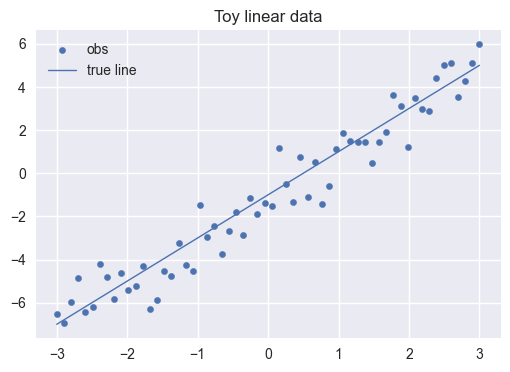

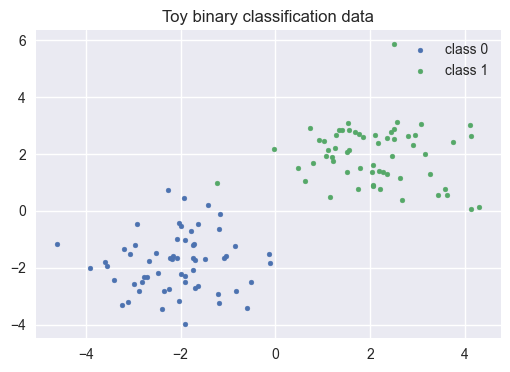

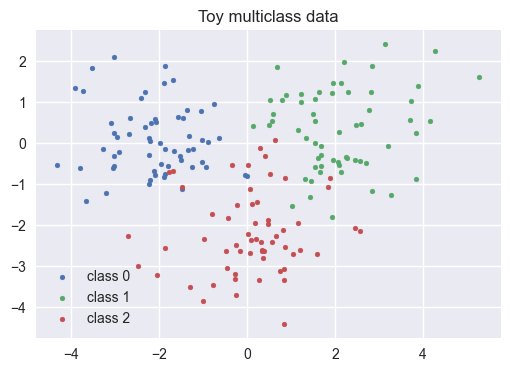

In [13]:

# Create toy datasets for line-fitting and classification
def make_linear_data(n=60, noise=1.0):
    X = np.linspace(-3, 3, n)
    y_true = 2.0*X - 1.0
    y = y_true + np.random.randn(n)*noise
    return X.reshape(-1,1), y, y_true

def make_binary_blobs(n=120, sep=2.0):
    # Two blobs in 2D
    n_per = n//2
    mean0 = np.array([-sep, -sep])
    mean1 = np.array([ sep,  sep])
    X0 = np.random.randn(n_per, 2) + mean0
    X1 = np.random.randn(n - n_per, 2) + mean1
    X = np.vstack([X0, X1])
    y = np.hstack([np.zeros(n_per, dtype=int), np.ones(n - n_per, dtype=int)])
    return X, y

def make_multiclass_blobs(n=180, sep=2.2):
    # Three classes
    n_per = n//3
    means = [np.array([-sep, 0.0]), np.array([sep, 0.5]), np.array([0.0, -sep])]
    Xs = []
    ys = []
    for k, m in enumerate(means):
        Xk = np.random.randn(n_per, 2) + m
        yk = np.full(n_per, k, dtype=int)
        Xs.append(Xk)
        ys.append(yk)
    X = np.vstack(Xs)
    y = np.hstack(ys)
    return X, y

# Quick peek at datasets
X_lin, y_lin, y_true_lin = make_linear_data()
X_bin, y_bin = make_binary_blobs()
X_multi, y_multi = make_multiclass_blobs()

fig, ax = plt.subplots()
ax.scatter(X_lin[:,0], y_lin, s=20, label="obs")
ax.plot(X_lin[:,0], y_true_lin, linewidth=1, label="true line")
ax.set_title("Toy linear data")
ax.legend()
plt.show()

fig, ax = plt.subplots()
ax.scatter(X_bin[y_bin==0,0], X_bin[y_bin==0,1], s=12, label="class 0")
ax.scatter(X_bin[y_bin==1,0], X_bin[y_bin==1,1], s=12, label="class 1")
ax.set_title("Toy binary classification data")
ax.legend()
plt.show()

fig, ax = plt.subplots()
for k in np.unique(y_multi):
    ax.scatter(X_multi[y_multi==k,0], X_multi[y_multi==k,1], s=12, label=f"class {k}")
ax.set_title("Toy multiclass data")
ax.legend()
plt.show()



## Linear Regression — Geometry and Derivation

**Model:** $ \hat{y} = x^\top \theta $ (with a bias term handled by adding a constant feature).  
**Objective (Least Squares):** Minimize the average squared error:
$
J(\theta)=\frac{1}{n}\sum_{i=1}^n (x_i^\top\theta - y_i)^2.
$

**Vector form:** Let $X\in\mathbb{R}^{n\times d}$ (with a column of ones for bias) and $y\in\mathbb{R}^n$.  
Then $J(\theta) = \frac{1}{n}\lVert X\theta - y\rVert_2^2$.

### Normal Equations (closed form)
If $X^\top X$ is invertible:
$$
\nabla_\theta J(\theta) = \frac{2}{n}X^\top(X\theta - y) = 0

\;\;\Rightarrow\;\;

\theta^\star = (X^\top X)^{-1}X^\top y.

$$

### Geometry
- $X\theta$ is the projection of $y$ onto the column space of $X$.
- The residual $r = y - X\theta^\star$ is orthogonal to every column of $X$.


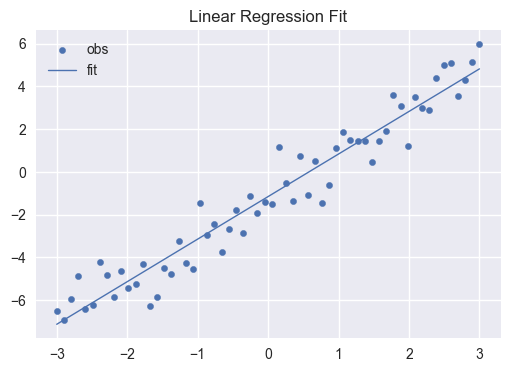

interactive(children=(FloatSlider(value=0.05, description='learning rate', max=0.5, min=0.001, step=0.001), In…

In [14]:

# Linear regression: closed-form and gradient descent with visualization
def add_bias_column(X):
    return np.hstack([np.ones((X.shape[0], 1)), X])

def fit_normal_eq(X, y):
    Xb = add_bias_column(X)
    theta = np.linalg.pinv(Xb.T @ Xb) @ Xb.T @ y
    return theta  # shape (d+1,)

def predict_lin(X, theta):
    Xb = add_bias_column(X)
    return Xb @ theta

def gd_linear(X, y, lr=0.05, steps=200):
    Xb = add_bias_column(X)  # (n,d+1)
    theta = np.zeros(Xb.shape[1])
    losses = []
    for t in range(steps):
        yhat = Xb @ theta
        grad = (2.0/len(X)) * (Xb.T @ (yhat - y))
        theta -= lr * grad
        loss = np.mean((yhat - y)**2)
        losses.append(loss)
    return theta, np.array(losses)

# Visualize and interact
theta_closed = fit_normal_eq(X_lin, y_lin)

def plot_lin(theta):
    fig, ax = plt.subplots()
    ax.scatter(X_lin[:,0], y_lin, s=20, label="obs")
    xs = np.linspace(X_lin[:,0].min(), X_lin[:,0].max(), 200).reshape(-1,1)
    preds = predict_lin(xs, theta)
    ax.plot(xs[:,0], preds, linewidth=1, label="fit")
    ax.set_title("Linear Regression Fit")
    ax.legend()
    plt.show()

plot_lin(theta_closed)

if HAS_WIDGETS:
    def demo_lr(lr=0.05, steps=100):
        theta_gd, losses = gd_linear(X_lin, y_lin, lr=lr, steps=steps)
        plot_lin(theta_gd)
        fig, ax = plt.subplots()
        ax.plot(np.arange(len(losses)), losses)
        ax.set_xlabel("step")
        ax.set_ylabel("MSE")
        ax.set_title("Gradient Descent Loss (MSE)")
        plt.show()
    interact(demo_lr,
             lr=FloatSlider(min=0.001, max=0.5, step=0.001, value=0.05, description="learning rate"),
             steps=IntSlider(min=10, max=1000, step=10, value=200, description="steps"));
else:
    print("Widgets not available; showing closed-form fit above.")



## Logistic Regression (Binary) — From Bernoulli Likelihood

**Model:** Predict $p(y=1\mid x)=\sigma(z)$ with $z = x^\top w + b$ and $\sigma(z)=\frac{1}{1+e^{-z}}$.  
**Labels:** $y\in\{0,1\}$.

**Bernoulli model:**
$
p(y\mid x) = p^{\,y}(1-p)^{1-y}, \quad p=\sigma(x^\top w + b).
$

**Log-likelihood for one sample:**
$
\log p(y\mid x) = y\log p + (1-y)\log(1-p).
$

**Loss (negative log-likelihood, averaged):**
$
J(w,b) = -\frac{1}{n}\sum_{i=1}^n \Big( y_i\log p_i + (1-y_i)\log(1-p_i) \Big),
\quad p_i=\sigma(x_i^\top w + b).
$

### Gradient (vectorized)
Let $X\in\mathbb{R}^{n\times d}$ and $w\in\mathbb{R}^d$, $b\in\mathbb{R}$.  
Define $\hat{p}=\sigma(Xw + b)$ elementwise. Then:
$
\nabla_w J = \frac{1}{n} X^\top(\hat{p}-y), \qquad
\frac{\partial J}{\partial b} = \frac{1}{n}\sum_{i=1}^n (\hat{p}_i - y_i).
$

> Intuition: the residual is **probability error** $(\hat{p}-y)$; we nudge $w,b$ to reduce it.


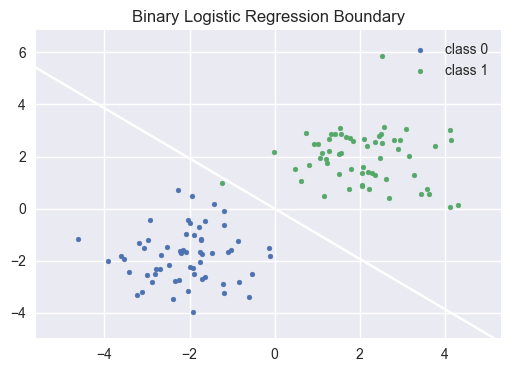

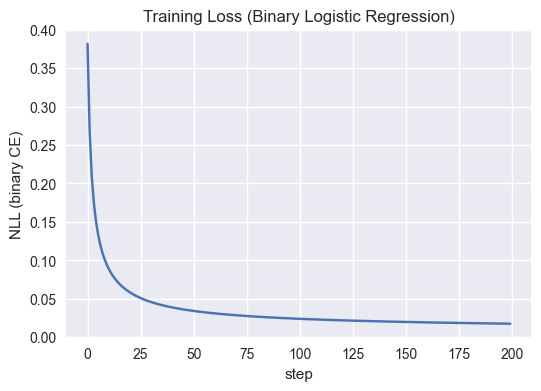

interactive(children=(IntSlider(value=200, description='steps', max=1000, min=10, step=10), FloatSlider(value=…

In [15]:

# Logistic regression from scratch (binary)
def sigmoid(z):
    # stable sigmoid
    # for large magnitude z, avoid overflow
    out = np.empty_like(z, dtype=float)
    pos = z >= 0
    neg = ~pos
    out[pos] = 1.0 / (1.0 + np.exp(-z[pos]))
    ez = np.exp(z[neg])
    out[neg] = ez / (1.0 + ez)
    return out

def predict_proba_logreg(X, w, b):
    return sigmoid(X @ w + b)

def nll_bin(X, y, w, b):
    p = predict_proba_logreg(X, w, b)
    eps = 1e-12
    return -np.mean(y*np.log(p+eps) + (1-y)*np.log(1-p+eps))

def gd_logreg(X, y, lr=0.1, steps=200):
    w = np.zeros(X.shape[1])
    b = 0.0
    losses = []
    for t in range(steps):
        p = predict_proba_logreg(X, w, b)
        grad_w = (X.T @ (p - y)) / len(X)
        grad_b = np.mean(p - y)
        w -= lr * grad_w
        b -= lr * grad_b
        losses.append(nll_bin(X, y, w, b))
    return w, b, np.array(losses)

def plot_decision_boundary(X, y, w, b, title="Decision Boundary"):
    # Only for 2D X
    x_min, x_max = X[:,0].min()-1, X[:,0].max()+1
    y_min, y_max = X[:,1].min()-1, X[:,1].max()+1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    grid = np.c_[xx.ravel(), yy.ravel()]
    probs = predict_proba_logreg(grid, w, b).reshape(xx.shape)
    fig, ax = plt.subplots()
    # decision boundary at p=0.5
    cs = ax.contour(xx, yy, probs, levels=[0.5])
    for cls in np.unique(y):
        ax.scatter(X[y==cls,0], X[y==cls,1], s=12, label=f"class {cls}")
    ax.set_title(title)
    ax.legend()
    plt.show()

w_bin, b_bin, losses_bin = gd_logreg(X_bin, y_bin, lr=0.2, steps=200)
plot_decision_boundary(X_bin, y_bin, w_bin, b_bin, title="Binary Logistic Regression Boundary")

fig, ax = plt.subplots()
ax.plot(np.arange(len(losses_bin)), losses_bin)
ax.set_xlabel("step")
ax.set_ylabel("NLL (binary CE)")
ax.set_title("Training Loss (Binary Logistic Regression)")
plt.show()

if HAS_WIDGETS:
    def train_steps(steps=50, lr=0.2):
        w, b, losses = gd_logreg(X_bin, y_bin, lr=lr, steps=steps)
        plot_decision_boundary(X_bin, y_bin, w, b, title=f"Boundary after {steps} steps")
        fig, ax = plt.subplots()
        ax.plot(np.arange(len(losses)), losses)
        ax.set_xlabel("step")
        ax.set_ylabel("NLL")
        ax.set_title("Loss Curve")
        plt.show()
    interact(train_steps,
             steps=IntSlider(min=10, max=1000, step=10, value=200, description="steps"),
             lr=FloatSlider(min=0.01, max=1.0, step=0.01, value=0.2, description="lr"));



## Multinomial Logistic Regression (Softmax) — Intuition & Math

**Setup:** $K$ classes, one-hot label $Y_i\in\{0,1\}^K$ with exactly one 1 at the true class index $y_i$.  
**Scores:** $z_i = X_i W \in \mathbb{R}^K$.  
**Softmax probabilities:**
$
P_{ik} = \frac{e^{z_{ik}}}{\sum_{j=1}^K e^{z_{ij}}}.
$

**Stable softmax (log-sum-exp trick):**
$
P_{ik} = \frac{e^{z_{ik}-m_i}}{\sum_{j=1}^K e^{z_{ij}-m_i}},\quad m_i=\max_j z_{ij}.
$

**Cross-entropy loss:**
$
J(W)= -\frac{1}{n}\sum_{i=1}^n \sum_{k=1}^K Y_{ik}\log P_{ik}
= -\frac{1}{n}\sum_{i=1}^n \log P_{i,y_i}.
$

**Gradient (vectorized):**
$
\nabla_W J = \frac{1}{n} X^\top (P - Y),\quad
\text{where } X\in\mathbb{R}^{n\times d},\; P,Y\in\mathbb{R}^{n\times K}.
$

> Intuition: $P-Y$ is a **probability error** matrix; $X^\top(P-Y)$ aggregates input-weighted errors for all classes.


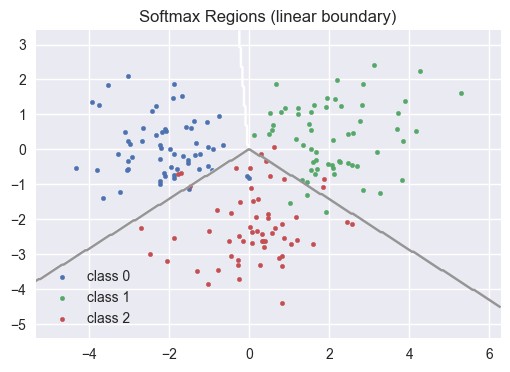

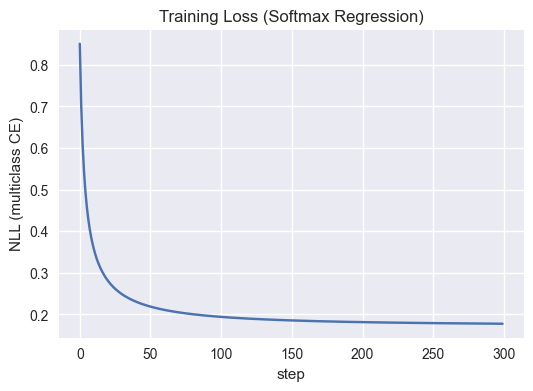

interactive(children=(IntSlider(value=300, description='steps', max=1000, min=50, step=50), FloatSlider(value=…

In [16]:

# Softmax regression from scratch (multiclass)
def softmax_stable(Z):
    # Z: (n, K)
    Z = Z - Z.max(axis=1, keepdims=True)
    expZ = np.exp(Z)
    return expZ / expZ.sum(axis=1, keepdims=True)

def one_hot(y, K):
    Y = np.zeros((y.shape[0], K))
    Y[np.arange(y.shape[0]), y] = 1.0
    return Y

def nll_softmax(X, y, W):
    Z = X @ W
    P = softmax_stable(Z)
    eps = 1e-12
    return -np.mean(np.log(P[np.arange(len(y)), y] + eps))

def gd_softmax(X, y, K, lr=0.1, steps=300):
    d = X.shape[1]
    W = np.zeros((d, K))
    losses = []
    for t in range(steps):
        Z = X @ W
        P = softmax_stable(Z)      # (n, K)
        Y = one_hot(y, K)          # (n, K)
        grad = (X.T @ (P - Y)) / len(X)   # (d, K)
        W -= lr * grad
        losses.append(nll_softmax(X, y, W))
    return W, np.array(losses)

def plot_softmax_boundary(X, y, W, title="Softmax Decision Regions"):
    x_min, x_max = X[:,0].min()-1, X[:,0].max()+1
    y_min, y_max = X[:,1].min()-1, X[:,1].max()+1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = grid @ W
    P = softmax_stable(Z)
    pred = np.argmax(P, axis=1).reshape(xx.shape)
    fig, ax = plt.subplots()
    # contour lines for class boundaries
    cs = ax.contour(xx, yy, pred, levels=np.arange(np.max(pred)+1))
    for cls in np.unique(y):
        ax.scatter(X[y==cls,0], X[y==cls,1], s=10, label=f"class {cls}")
    ax.set_title(title)
    ax.legend()
    plt.show()

# Train on toy multiclass data (add bias column for linear scores)
X_m = np.hstack([np.ones((X_multi.shape[0],1)), X_multi])  # bias
K = len(np.unique(y_multi))
W_soft, losses_soft = gd_softmax(X_m, y_multi, K=K, lr=0.2, steps=300)

plot_softmax_boundary(X_multi, y_multi, W_soft[1:,:], title="Softmax Regions (linear boundary)")

fig, ax = plt.subplots()
ax.plot(np.arange(len(losses_soft)), losses_soft)
ax.set_xlabel("step")
ax.set_ylabel("NLL (multiclass CE)")
ax.set_title("Training Loss (Softmax Regression)")
plt.show()

if HAS_WIDGETS:
    def softmax_steps(steps=100, lr=0.2):
        W, losses = gd_softmax(X_m, y_multi, K=K, lr=lr, steps=steps)
        plot_softmax_boundary(X_multi, y_multi, W[1:,:], title=f"Softmax Regions after {steps} steps")
        fig, ax = plt.subplots()
        ax.plot(np.arange(len(losses)), losses)
        ax.set_xlabel("step")
        ax.set_ylabel("NLL")
        ax.set_title("Loss Curve")
        plt.show()
    interact(softmax_steps,
             steps=IntSlider(min=50, max=1000, step=50, value=300, description="steps"),
             lr=FloatSlider(min=0.01, max=1.0, step=0.01, value=0.2, description="lr"));



## Wrap-up & Quick Checks

- **Linear Regression:** Least squares projection, closed-form $(X^\top X)^{-1}X^\top y$ and gradient descent.
- **Logistic Regression (Binary):** Bernoulli likelihood $\Rightarrow$ cross-entropy. Sigmoid link, linear boundary in 2D.
- **Multinomial (Softmax):** One-hot labels, cross-entropy, vectorized gradient $X^\top(P-Y)$.
